# Loading and saving the dataset

In [1]:
from datasets import load_dataset

# Load dataset from huggingface
dataset = load_dataset("Micol/musical-instruments-sound-dataset")

In [2]:
# Optional -> save to disk to prevent re-download
# dataset.save_to_disk("data/")

---------
# Dataset preprocessing

In [3]:
import torch
from torchaudio.transforms import MelSpectrogram, Resample
from torch.utils.data import DataLoader, Dataset as TorchDataset

In [4]:
# Define a custom PyTorch Dataset for pre-processing
class AudioDataset(TorchDataset):
    def __init__(self, dataset, target_sr=16000, fixed_duration=2):  # Fixed duration is now 2 seconds
        """
        Custom PyTorch Dataset for audio classification.
        
        Args:
            dataset: Hugging Face dataset containing 'audio' and 'label' columns.
            target_sr: Target sampling rate to resample all audio.
            fixed_duration: Fixed duration for all audio clips (in seconds).
        """
        self.dataset = dataset
        self.target_sr = target_sr
        self.num_samples = target_sr * fixed_duration

        # Mel Spectrogram transform
        self.mel_transform = MelSpectrogram(
            sample_rate=target_sr, 
            n_fft=1024, 
            hop_length=512, 
            n_mels=64
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load audio and label
        audio_array = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
        
        # Convert to PyTorch tensor
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        # Resample if needed
        if sr != self.target_sr:
            resample_transform = Resample(orig_freq=sr, new_freq=self.target_sr)
            audio_tensor = resample_transform(audio_tensor)

        # Find the loudest part of the audio
        max_idx = torch.argmax(audio_tensor)  # Find index of the loudest part
        start_idx = max(0, max_idx - self.target_sr)  # One second to the left
        end_idx = min(audio_tensor.size(0), max_idx + self.target_sr)  # One second to the right

        audio_tensor = audio_tensor[start_idx:end_idx]

        # Pad or truncate to fixed length
        if audio_tensor.shape[0] > self.num_samples:
            audio_tensor = audio_tensor[:self.num_samples]  # Truncate
        else:
            padding = self.num_samples - audio_tensor.shape[0]
            audio_tensor = torch.nn.functional.pad(audio_tensor, (0, padding))  # Pad with zeros

        # Convert to Mel Spectrogram
        mel_spectrogram = self.mel_transform(audio_tensor)

        return mel_spectrogram, label

In [5]:
# Split dataset into train and test sets
train_dataset = AudioDataset(dataset['train'])
validation_dataset = AudioDataset(dataset['validation'])
test_dataset = AudioDataset(dataset['test'])

In [6]:
# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

----
# Model implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: [16, 64, 63]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # Output: [32, 32, 32]
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # Output: [64, 16, 16]

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Flattened size
        self.fc2 = nn.Linear(256, num_classes)   # Output layer

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Input shape: [batch_size, 1, 64, 63]
        x = F.relu(self.conv1(x))  # [batch_size, 16, 64, 63]
        x = F.relu(self.conv2(x))  # [batch_size, 32, 32, 32]
        x = F.relu(self.conv3(x))  # [batch_size, 64, 16, 16]

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [9]:
# Number of classes based on dataset
num_classes = len(dataset['train'].features['label'].names)

# Instantiate the model
model = AudioClassifier(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [10]:
from tqdm import tqdm

# train loop
def train(model, train_loader, validation_loader, criterion, optimizer, device, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training phase
        for mel_spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            # Forward pass
            outputs = model(mel_spectrograms)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrograms, labels in validation_loader:
                mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

                outputs = model(mel_spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        accuracy = correct / total

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {accuracy:.4f}")

In [11]:
train(model, train_loader, validation_loader, criterion, optimizer, device, epochs=50)

Epoch 1/50: 100%|██████████| 66/66 [00:57<00:00,  1.14it/s]


Epoch 1: Train Loss = 3.8811, Val Loss = 1.1950, Val Accuracy = 0.4677


Epoch 2/50: 100%|██████████| 66/66 [00:55<00:00,  1.20it/s]


Epoch 2: Train Loss = 0.9042, Val Loss = 0.8851, Val Accuracy = 0.5779


Epoch 3/50: 100%|██████████| 66/66 [00:54<00:00,  1.20it/s]


Epoch 3: Train Loss = 0.7412, Val Loss = 0.7838, Val Accuracy = 0.5532


Epoch 4/50: 100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


Epoch 4: Train Loss = 0.6940, Val Loss = 0.7976, Val Accuracy = 0.6046


Epoch 5/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 5: Train Loss = 0.6581, Val Loss = 0.8272, Val Accuracy = 0.6084


Epoch 6/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 6: Train Loss = 0.6479, Val Loss = 0.9013, Val Accuracy = 0.5741


Epoch 7/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 7: Train Loss = 0.5846, Val Loss = 0.7774, Val Accuracy = 0.6255


Epoch 8/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 8: Train Loss = 0.5680, Val Loss = 0.8837, Val Accuracy = 0.5703


Epoch 9/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 9: Train Loss = 0.5780, Val Loss = 0.8124, Val Accuracy = 0.6065


Epoch 10/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 10: Train Loss = 0.5675, Val Loss = 0.7078, Val Accuracy = 0.6369


Epoch 11/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 11: Train Loss = 0.4915, Val Loss = 0.7132, Val Accuracy = 0.5875


Epoch 12/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 12: Train Loss = 0.4649, Val Loss = 0.8522, Val Accuracy = 0.6198


Epoch 13/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 13: Train Loss = 0.5135, Val Loss = 0.8594, Val Accuracy = 0.6255


Epoch 14/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 14: Train Loss = 0.4776, Val Loss = 0.8120, Val Accuracy = 0.5913


Epoch 15/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 15: Train Loss = 0.4608, Val Loss = 0.9473, Val Accuracy = 0.5627


Epoch 16/50: 100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


Epoch 16: Train Loss = 0.4591, Val Loss = 0.8287, Val Accuracy = 0.6008


Epoch 17/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 17: Train Loss = 0.4206, Val Loss = 0.9009, Val Accuracy = 0.5551


Epoch 18/50: 100%|██████████| 66/66 [00:54<00:00,  1.21it/s]


Epoch 18: Train Loss = 0.4076, Val Loss = 0.8805, Val Accuracy = 0.6217


Epoch 19/50: 100%|██████████| 66/66 [00:55<00:00,  1.19it/s]


Epoch 19: Train Loss = 0.4813, Val Loss = 0.9576, Val Accuracy = 0.6464


Epoch 20/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 20: Train Loss = 0.5041, Val Loss = 1.0410, Val Accuracy = 0.6141


Epoch 21/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 21: Train Loss = 0.4688, Val Loss = 0.7710, Val Accuracy = 0.6312


Epoch 22/50: 100%|██████████| 66/66 [00:53<00:00,  1.22it/s]


Epoch 22: Train Loss = 0.4478, Val Loss = 0.8199, Val Accuracy = 0.5741


Epoch 23/50: 100%|██████████| 66/66 [00:53<00:00,  1.23it/s]


Epoch 23: Train Loss = 0.4200, Val Loss = 0.6945, Val Accuracy = 0.5817


Epoch 24/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 24: Train Loss = 0.4348, Val Loss = 0.7152, Val Accuracy = 0.6046


Epoch 25/50: 100%|██████████| 66/66 [00:52<00:00,  1.27it/s]


Epoch 25: Train Loss = 0.3980, Val Loss = 0.8564, Val Accuracy = 0.5894


Epoch 26/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 26: Train Loss = 0.3877, Val Loss = 0.8111, Val Accuracy = 0.5665


Epoch 27/50: 100%|██████████| 66/66 [00:52<00:00,  1.27it/s]


Epoch 27: Train Loss = 0.3858, Val Loss = 0.7461, Val Accuracy = 0.5513


Epoch 28/50: 100%|██████████| 66/66 [00:52<00:00,  1.27it/s]


Epoch 28: Train Loss = 0.3805, Val Loss = 0.9355, Val Accuracy = 0.5532


Epoch 29/50: 100%|██████████| 66/66 [00:52<00:00,  1.27it/s]


Epoch 29: Train Loss = 0.3765, Val Loss = 0.8811, Val Accuracy = 0.5684


Epoch 30/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 30: Train Loss = 0.4128, Val Loss = 0.9031, Val Accuracy = 0.5856


Epoch 31/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 31: Train Loss = 0.4321, Val Loss = 0.8101, Val Accuracy = 0.6236


Epoch 32/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 32: Train Loss = 0.4120, Val Loss = 0.8508, Val Accuracy = 0.5608


Epoch 33/50: 100%|██████████| 66/66 [00:51<00:00,  1.27it/s]


Epoch 33: Train Loss = 0.3826, Val Loss = 1.0211, Val Accuracy = 0.5494


Epoch 34/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 34: Train Loss = 0.3959, Val Loss = 0.8640, Val Accuracy = 0.5665


Epoch 35/50: 100%|██████████| 66/66 [00:51<00:00,  1.27it/s]


Epoch 35: Train Loss = 0.3759, Val Loss = 0.9275, Val Accuracy = 0.5837


Epoch 36/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 36: Train Loss = 0.4119, Val Loss = 1.3043, Val Accuracy = 0.5722


Epoch 37/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 37: Train Loss = 0.4763, Val Loss = 0.8467, Val Accuracy = 0.6122


Epoch 38/50: 100%|██████████| 66/66 [00:52<00:00,  1.27it/s]


Epoch 38: Train Loss = 0.4105, Val Loss = 0.7802, Val Accuracy = 0.5722


Epoch 39/50: 100%|██████████| 66/66 [00:51<00:00,  1.27it/s]


Epoch 39: Train Loss = 0.3894, Val Loss = 0.9542, Val Accuracy = 0.5437


Epoch 40/50: 100%|██████████| 66/66 [00:52<00:00,  1.26it/s]


Epoch 40: Train Loss = 0.3842, Val Loss = 0.8931, Val Accuracy = 0.5970


Epoch 41/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 41: Train Loss = 0.3751, Val Loss = 0.8756, Val Accuracy = 0.5437


Epoch 42/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 42: Train Loss = 0.3763, Val Loss = 0.9075, Val Accuracy = 0.5703


Epoch 43/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 43: Train Loss = 0.3698, Val Loss = 0.9984, Val Accuracy = 0.5437


Epoch 44/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 44: Train Loss = 0.3671, Val Loss = 0.9603, Val Accuracy = 0.5285


Epoch 45/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 45: Train Loss = 0.3650, Val Loss = 0.9853, Val Accuracy = 0.5551


Epoch 46/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 46: Train Loss = 0.3775, Val Loss = 1.0960, Val Accuracy = 0.5209


Epoch 47/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 47: Train Loss = 0.3707, Val Loss = 1.0498, Val Accuracy = 0.5513


Epoch 48/50: 100%|██████████| 66/66 [00:53<00:00,  1.24it/s]


Epoch 48: Train Loss = 0.3638, Val Loss = 1.0792, Val Accuracy = 0.5532


Epoch 49/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 49: Train Loss = 0.3710, Val Loss = 1.1129, Val Accuracy = 0.5551


Epoch 50/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 50: Train Loss = 0.3718, Val Loss = 1.0855, Val Accuracy = 0.5228


-----
# Evaluate

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 0.5375
Confusion Matrix:


<Figure size 1000x700 with 0 Axes>

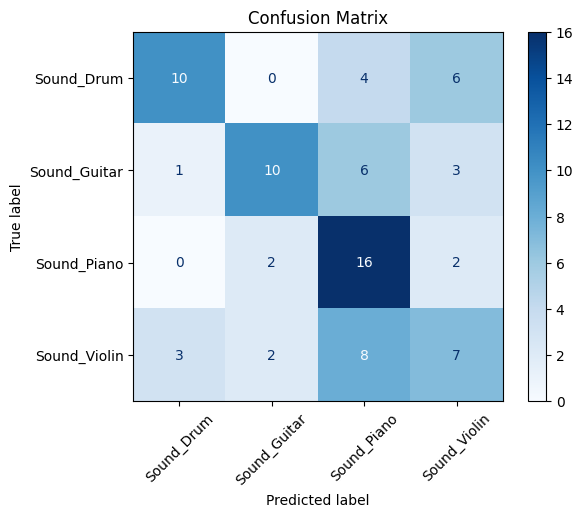

In [13]:
def evaluate(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spectrograms, labels in test_loader:
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            outputs = model(mel_spectrograms)
            _, predicted = torch.max(outputs, 1)

            # Track overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Evaluate on test set
evaluate(model, test_loader, device, dataset['train'].features['label'].names)

In [14]:
torch.save(model, 'second_idea.pth')